In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs
import pmdarima as pm

In [2]:
def check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(15, 10)):
    """ Checks the stationarity of a pandas Series (default is daily prices or returns),
        using plots, correlograms and the ADF test
    """
    ## Calculating rolling statistics
    
    rolling_wl1_mean = y.rolling(window=wl1).mean()
    rolling_wl2_mean = y.rolling(window=wl2).mean()
    rolling_wl1_vol = y.rolling(window=wl1).std()
    rolling_wl2_vol = y.rolling(window=wl2).std()
    
    ## Plotting the price, rolling statistics and correlograms
    
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=1)
    layout = (2, 2)
    y_ax = plt.subplot2grid(layout, (0, 0))
    vol_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=y_ax)
    rolling_wl1_mean.plot(ax=y_ax)
    rolling_wl2_mean.plot(ax=y_ax)
    
    rolling_wl1_vol.plot(ax=vol_ax)
    rolling_wl2_vol.plot(ax=vol_ax)
    y_ax.set_title('Rolling means over time')
    y_ax.legend(['observed', f'{wl1}-period MA of observed', f'{wl2}-period MA of observed'], loc='best')
    #y_ax.set_ylabel("Gold prices(in INR)/oz.")
    
    vol_ax.set_title('Rolling volatility over time')
    vol_ax.legend([f'{wl1}-period MA of volatility', f'{wl2}-period MA of volatility'], loc='best')
    
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    
    ## Running the Augmented Dickey-Fuller test
    print('--------------------------------------------------------------')
    print('--------- The augmented Dickey-Fuller test results -----------')
    print('--------------------------------------------------------------')
    adftest = adfuller(y, autolag='AIC')
    results = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags','# of Observations'])
    for key,value in adftest[4].items():
        results[f'Critical Value ({key})'] = '{0:.3f}'.format(value)
    print(results)
    print('--------------------------------------------------------------')

In [3]:
start = datetime.date(2010, 6, 30)
end = datetime.date(2019, 7, 1)
ticker = "NFLX"

In [4]:
df = yf.download(ticker, start=start, end=end, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker} data")

Downloaded 2266 rows and 6 columns of NFLX data


In [5]:
nflx = df.copy()
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

nflx = nflx.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [6]:
nflx.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
nflx.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(nflx.tail())

             adj_close
Date                  
2019-06-02  343.279999
2019-06-09  360.869995
2019-06-16  339.730011
2019-06-23  369.209991
2019-06-30  367.320007


In [7]:
## Checking for null values

nflx[nflx['adj_close'].isnull()]

,adj_close
Date,


In [8]:
start_str = (start + pd.Timedelta("5 days")).strftime("%B %Y")
end_str = (end - pd.Timedelta("5 days")).strftime("%B %Y")

In [9]:
start_str

'July 2010'

In [10]:
end_str

'June 2019'

<IPython.core.display.Javascript object>

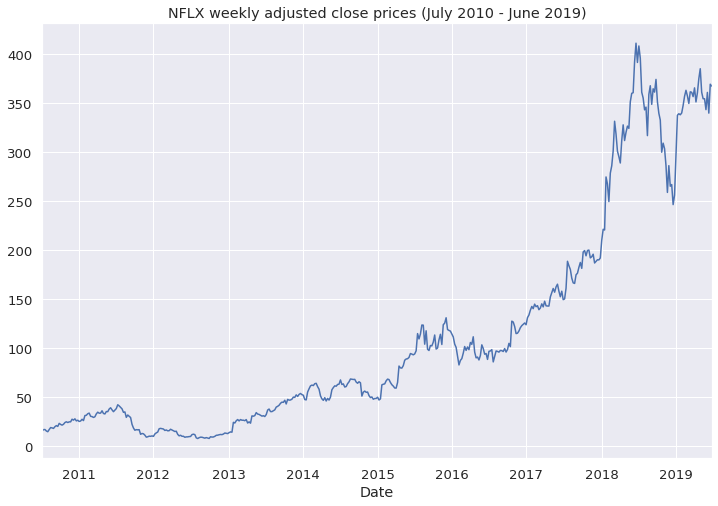

In [11]:
sns.set(font_scale=1.2)
nflx['adj_close'].plot(figsize=(12, 8), title=f"{ticker} weekly adjusted close prices ({start_str} - {end_str})");

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic          0.507267
p-value                 0.985092
# of Lags                   16.0
# of Observations          453.0
Critical Value (1%)       -3.445
Critical Value (5%)       -2.868
Critical Value (10%)      -2.570
dtype: object
--------------------------------------------------------------


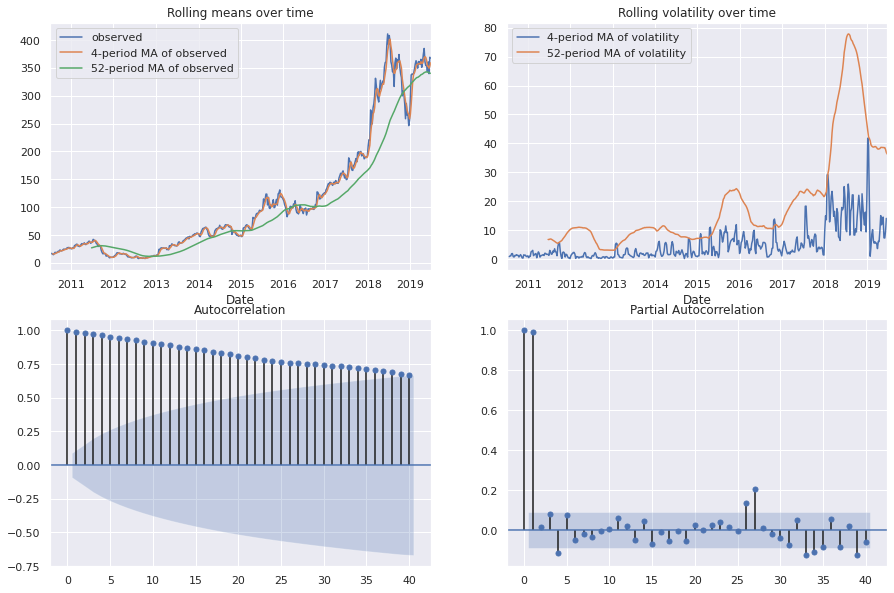

In [12]:
check_stationarity(nflx['adj_close'], wl1=4, wl2=52)

In [13]:
nflx['log_returns'] = np.log(nflx['adj_close']/nflx['adj_close'].shift(1))
nflx.dropna(axis='rows', how='any', inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -21.695175
p-value                       0.0
# of Lags                     0.0
# of Observations           468.0
Critical Value (1%)        -3.444
Critical Value (5%)        -2.868
Critical Value (10%)       -2.570
dtype: object
--------------------------------------------------------------


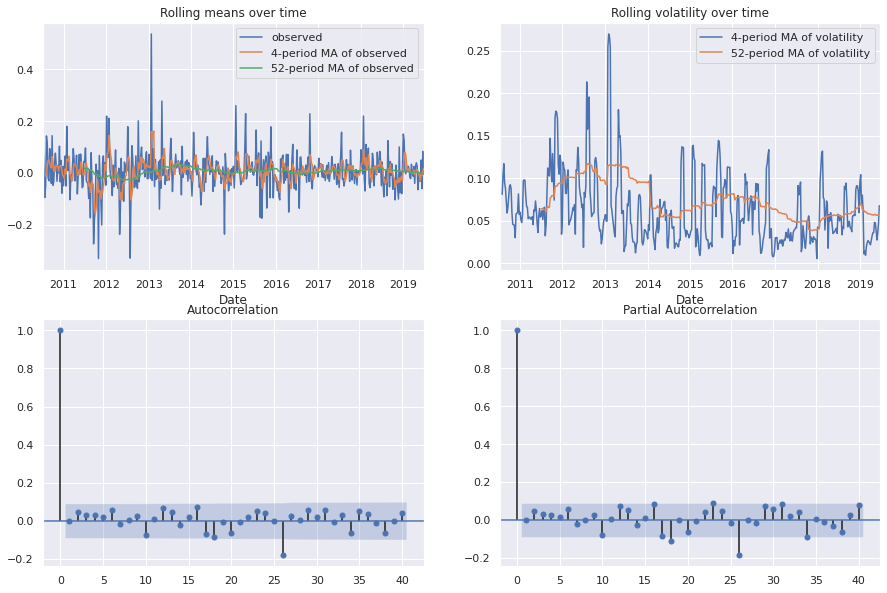

In [14]:
check_stationarity(nflx['log_returns'], wl1=4, wl2=52)

In [15]:
## Defining the model by providing the training set and providing the parameters p, d, q
arima_model = ARIMA(nflx['adj_close'], order=(3, 1, 2))

## Fitting the model, disp=0 is to switch off verbose display
arima_fit1 = arima_model.fit(disp=0)

## Printing a summary of the model
arima_fit1.summary()

<IPython.core.display.Javascript object>

/home/abhishek/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  468
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1669.422
Method:                       css-mle   S.D. of innovations              8.567
Date:                Fri, 10 Dec 2021   AIC                           3352.843
Time:                        12:57:19   BIC                           3381.883
Sample:                    07-18-2010   HQIC                          3364.270
                         - 06-30-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7526      0.396      1.902      0.057      -0.023       1.528
ar.L1.D.adj_close    -0.4227      0.079     -5.331      0.000      -0.578      -0.267
ar.L2.D.adj_close    -0.8401      0.134     -6.281      0.000      -1.102      -0.578
ar.L3.D.adj_close     0.0338      0.060      0.559      0.576      -0.085       0.152
ma.L1.D.adj_close     0.3660      0.065      5.617      0.000       0.238       0.494
ma.L2.D.adj_close     0.8618      0.128      6.717      0.000       0.610       1.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2692           -1.0453j            1.0794           -0.2901
AR.2           -0.2692           +1.0453j            1.0794            0.2901
AR.3           25.3906           -0.0000j           25.3906           -0.0000
MA.1           -0.2123           -1.0561j            1.0772           -0.2816
MA.2           -0.2123           +1.0561j            1.0772            0.2816
-----------------------------------------------------------------------------
"""

In [16]:
def arima_diagnostics(resids_, figsize=(15, 9), n_lags=40):
    '''
    Diagnoses the fit of an ARIMA model by examining its residuals.
    Returns a chart with multiple plots
    '''
    # Creating placeholder subplots
    M = 2
    N = 2
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(M, N, figsize=figsize)

    r = resids_
    resids_ = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids_[~(np.isnan(resids_))]
    
    # Plotting residuals over time
    sns.lineplot(x=np.arange(len(resids_)), 
                 y=resids_, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Plotting the distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, color='green', linewidth=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ## 's' is for standardized line to compare the plot with a normal distribution
    ax3.set_title('Q-Q plot')

    # ACF plot
    sm.graphics.tsa.plot_acf(resids_, lags=n_lags, ax=ax4, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/abhishek/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

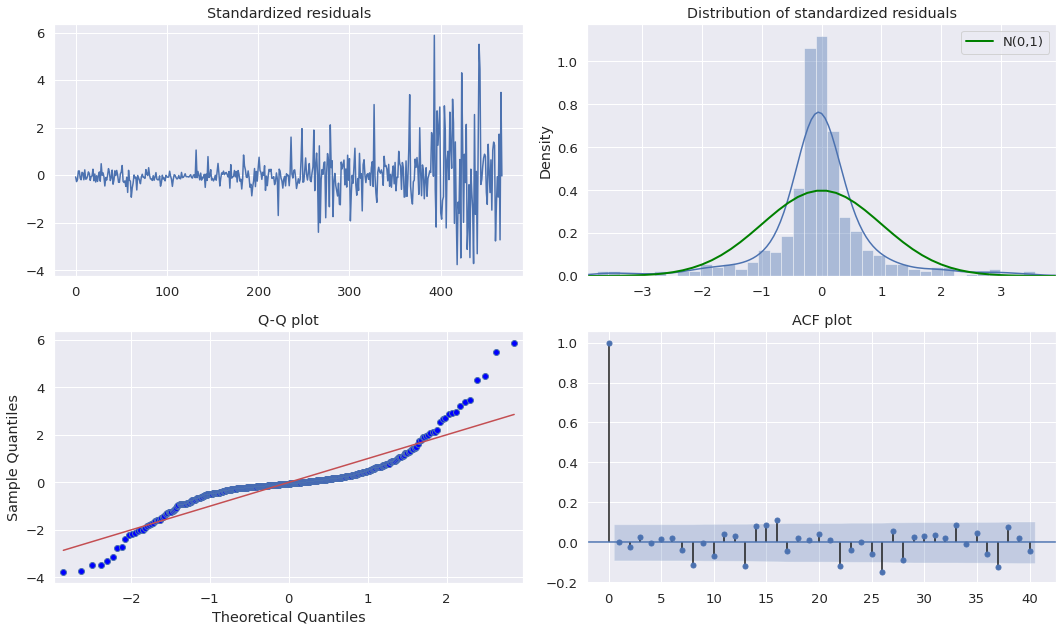

In [17]:
sns.set(font_scale=1.2)
arima_diagnostics(arima_fit1.resid)
plt.tight_layout()
plt.show();

<IPython.core.display.Javascript object>

/home/abhishek/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/home/abhishek/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'Lags'),
 Text(0.5, 1.0, 'Ljung-Box test results (after modeling NFLX stock prices)')]

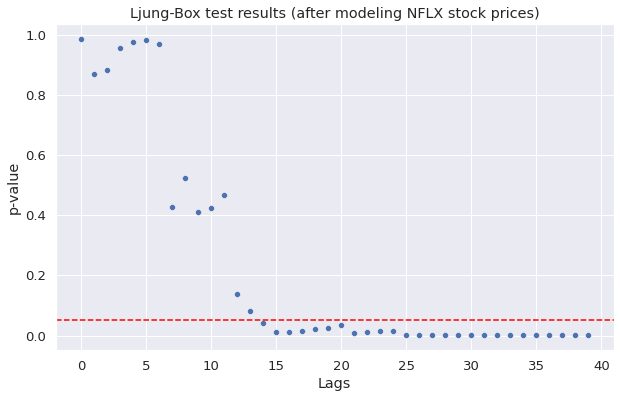

In [18]:
## Running the Ljung-Box test and plotting the results

ljung_box_results = sm.stats.acorr_ljungbox(arima_fit1.resid)
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', color='red')
ax.set(title=f"Ljung-Box test results (after modeling {ticker} stock prices)", xlabel='Lags', ylabel='p-value')

In [19]:
## Running the Jarque-Bera test and interpreting its results

from statsmodels.stats.stattools import jarque_bera

jb_test_stat, pvalue, _, _ = jarque_bera(arima_fit1.resid)
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")

if pvalue < 0.05:
    print("Residuals are likely not normally distributed.")
else:
    print("Residuals are likely normally distributed.")


Jarque-Bera statistic: 1287.88 with p-value: 0.00
Residuals are likely not normally distributed.


## Automatically finding the best ARIMA fit (using the pmdarima library)

In [20]:
nflx = nflx[['adj_close']]

In [21]:
# split our data into train and test set
Ntest = 12
train = nflx.iloc[:-Ntest]
test = nflx.iloc[-Ntest:]

In [22]:
## calling auto arima function and pass seasonal equals false
model = pm.auto_arima(train,
                     error_action='ignore', trace=True,
                     suppress_warnings=True, maxiter=10,
                     seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3241.309, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3242.826, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3244.481, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3244.469, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3244.559, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3245.906, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3247.503, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3236.906, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3241.255, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3243.010, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3364.356, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3244.198, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3242.545, Time=0.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3315.690, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  457
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1611.453
Date:                Fri, 10 Dec 2021   AIC                           3236.906
Time:                        12:57:25   BIC                           3265.763
Sample:                             0   HQIC                          3248.273
                                - 457                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9467      0.863      1.097      0.273      -0.744       2.638
ar.L1         -0.4174      0.099     -4.233      0.000      -0.611      -0.224
ar.L2         -0.5900      0.095     -6.206      0.000      -0.776      -0.404
ar.L3          0.1276      0.033      3.904      0.000       0.064       0.192
ma.L1          0.3986      0.090      4.443      0.000       0.223       0.575
ma.L2          0.5991      0.087      6.918      0.000       0.429       0.769
sigma2        68.0179      2.065     32.943      0.000      63.971      72.065
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1529.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              42.33   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (3, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [25]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]
    
    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True) 
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.2)
    ax.legend();
    

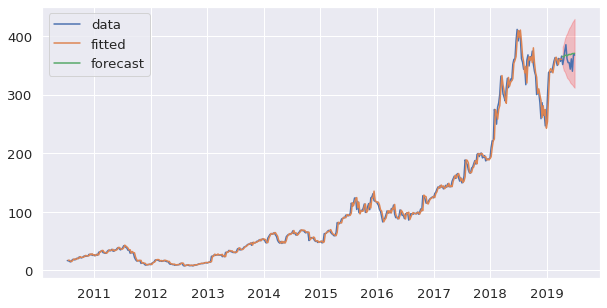

In [26]:
plot_result(model, nflx[['adj_close']], train, test)

In [27]:
def plot_test(model, test):    
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True) 
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.2)
    ax.legend();

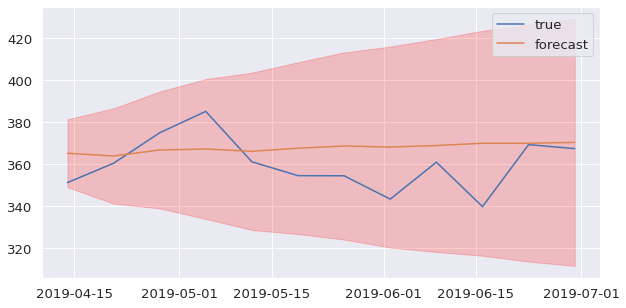

In [28]:
plot_test(model, test)

In [29]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [30]:
test.reset_index(drop=True, inplace=True)

In [31]:
print("RMSE ARIMA:", rmse(model.predict(Ntest), test.squeeze()))
print("RMSE Naive:", rmse(train.iloc[-1], test))

RMSE ARIMA: 14.67716580074455
RMSE Naive: adj_close    13.422767
dtype: float64
